In [61]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

from sklearn import preprocessing
import math

In [62]:
data=pd.read_csv("final_data.csv")

In [63]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [64]:
data.head()

,local_time,temp,pressure,rel_humidity,wind_dir,wind_speed
0,21.05.2020 11:30,40.6,731.3,14.0,Wind blowing from the north-west,5.0
1,21.05.2020 08:30,29.4,731.5,35.0,Wind blowing from the west,3.0
2,21.05.2020 05:30,27.0,730.7,41.0,Wind blowing from the south-southwest,2.0
3,21.05.2020 02:30,30.2,730.5,30.0,Wind blowing from the west,2.0
4,20.05.2020 23:30,32.4,731.4,23.0,Wind blowing from the west,2.0


In [65]:
data=data.drop(data.index[-1])

In [66]:
data=data[::-1]

In [67]:
data.isnull().any()

local_time      False
temp             True
pressure         True
rel_humidity     True
wind_dir         True
wind_speed       True
dtype: bool

In [68]:
data.loc[data['temp'].isnull(),'temp']=data['temp'].mean()
data.loc[data['pressure'].isnull(),'pressure']=data['pressure'].mean()
data.loc[data['rel_humidity'].isnull(),'rel_humidity']=data['rel_humidity'].mean()
data.loc[data['wind_speed'].isnull(),'wind_speed']=data['wind_speed'].mean()

In [69]:
data.isnull().any()

local_time      False
temp            False
pressure        False
rel_humidity    False
wind_dir         True
wind_speed      False
dtype: bool

In [70]:
TRAIN_SPLIT=8000
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [71]:
data.head()

,local_time,temp,pressure,rel_humidity,wind_dir,wind_speed
12866,07.12.2015 17:30,20.6,736.632556,65.0,Wind blowing from the south-east,2.0
12865,07.12.2015 20:30,17.4,736.632556,82.0,"Calm, no wind",0.0
12864,07.12.2015 23:30,15.8,736.632556,89.0,"Calm, no wind",0.0
12863,08.12.2015 02:30,15.0,736.632556,93.0,"Calm, no wind",0.0
12862,08.12.2015 05:30,14.2,736.632556,93.0,"Calm, no wind",0.0


In [72]:
train_data=data
test_data=data[9000:]
features=['temp','pressure','rel_humidity','wind_speed']
dataset=train_data[features]
dataset.index=train_data['local_time']

In [73]:
test_data.head()

,local_time,temp,pressure,rel_humidity,wind_dir,wind_speed
3866,15.01.2019 20:30,11.2,743.2,88.0,Wind blowing from the west-southwest,2.0
3865,15.01.2019 23:30,8.8,743.4,95.0,"Calm, no wind",0.0
3864,16.01.2019 02:30,7.4,743.2,97.0,"Calm, no wind",0.0
3863,16.01.2019 05:30,7.2,742.4,100.0,"Calm, no wind",0.0
3862,16.01.2019 08:30,7.8,744.1,99.0,Wind blowing from the west-southwest,2.0


In [74]:
dataset.head()

,temp,pressure,rel_humidity,wind_speed
local_time,,,,
07.12.2015 17:30,20.6,736.632556,65.0,2.0
07.12.2015 20:30,17.4,736.632556,82.0,0.0
07.12.2015 23:30,15.8,736.632556,89.0,0.0
08.12.2015 02:30,15.0,736.632556,93.0,0.0
08.12.2015 05:30,14.2,736.632556,93.0,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C4025A9E08>,
      dtype=object)

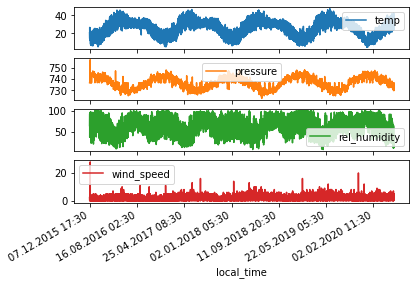

In [75]:
dataset.plot(subplots=True)

In [77]:
new_data=dataset.values

data_mean = new_data[:9000].mean(axis=0)
data_std = new_data[:9000].std(axis=0)

In [78]:
new_data=(new_data-data_mean)/data_std

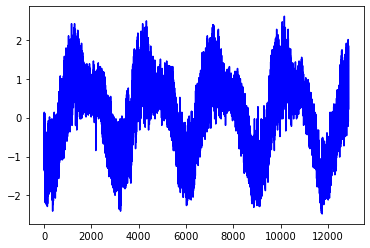

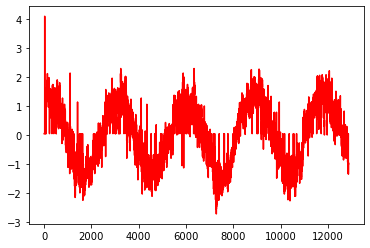

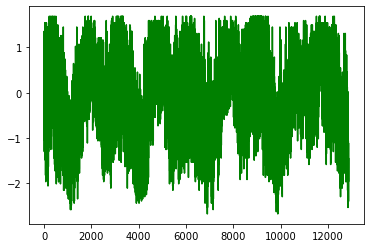

In [79]:
plt.figure(1)
plt.plot(new_data[:,0],color='blue')
plt.figure(2)
plt.plot(new_data[:,1],color='red')
plt.figure(3)
plt.plot(new_data[:,2],color='green')


In [80]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [81]:
new_data[0,1]

0.05675467799109947

In [82]:

past_history =120
future_target = 8
STEP = 1
x_train_single, y_train_single = multivariate_data(new_data, new_data[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(new_data, new_data[:, 1],
                                               TRAIN_SPLIT, 9000, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [83]:
x_test_single, y_test_single = multivariate_data(new_data, new_data[:, 1],
                                               9000, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [84]:
x_train_single.shape

(7880, 120, 4)

In [85]:
new_data.shape

(12867, 4)

In [86]:
y_train_single.shape

(7880,)

In [87]:
x_val_single.shape

(880, 120, 4)

In [88]:
y_val_single.shape

(880,)

In [89]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

In [90]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [91]:
EVALUATION_INTERVAL = 150
EPOCHS = 5
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 150 steps, validate for 50 steps
Epoch 1/5
150/150 [==============================] - 42s 280ms/step - loss: 0.2772 - val_loss: 0.2285
Epoch 2/5
150/150 [==============================] - 36s 237ms/step - loss: 0.2434 - val_loss: 0.2429
Epoch 3/5
150/150 [==============================] - 36s 237ms/step - loss: 0.2352 - val_loss: 0.2257
Epoch 4/5
150/150 [==============================] - 36s 238ms/step - loss: 0.2295 - val_loss: 0.2185
Epoch 5/5
150/150 [==============================] - 35s 232ms/step - loss: 0.2263 - val_loss: 0.2108


In [92]:
def squared_error(test_value,predict_value):
    error=0
    for i in range(len(test_value)):
        error=error+(test_value[i]-predict_value[i])**2
    return math.sqrt(error/len(test_value))

In [108]:
predicted_value=[]
expected_value=[]
for x, y in test_data_single.take(20):
  #plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
   #                 single_step_model.predict(x)[0]], 12,
    #               'Single Step Prediction')
    #print(single_step_model.predict(x)[0].shape)
    predicted_value.append((single_step_model.predict(x)[0])*data_std+data_mean)
    #predicted_value.append((single_step_model.predict(x)[0]))
    expected_value.append((y[0].numpy())*data_std+data_mean)
   # expected_value.append((y[0].numpy()))

In [109]:
predicted_value=np.array(predicted_value)
expected_value=np.array(expected_value)

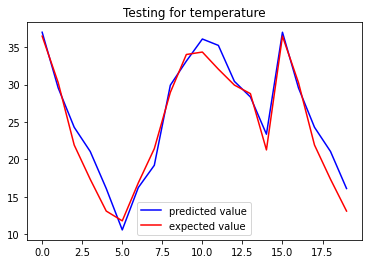

In [112]:
list1=predicted_value[:,0]
list2=expected_value[:,0]
plt.figure()
plt.plot(list(range(len(predicted_value))), list1, 'b', label='predicted value')
plt.plot(list(range(len(predicted_value))), list2, 'r', label='expected value')
plt.title("Testing for temperature")
plt.legend()

plt.show()

In [97]:
temperature_sq_error=squared_error(expected_value[:,0],predicted_value[:,0])
pressure_sq_error=squared_error(expected_value[:,1],predicted_value[:,1])
relative_humidity_sq_error=squared_error(expected_value[:,2],predicted_value[:,2])
wind_speed_sq_error=squared_error(expected_value[:,3],predicted_value[:,3])

In [98]:
print("temperature_sq_error=",temperature_sq_error)
print("pressure_sq_error=",pressure_sq_error)
print("relative_humidity_sq_error=",relative_humidity_sq_error)
print("wind_speed_sq_error=",wind_speed_sq_error)

temperature_sq_error= 2.0614589029413324
pressure_sq_error= 1.260914848650463
relative_humidity_sq_error= 5.203385939909244
wind_speed_sq_error= 0.4206526155310822


In [99]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

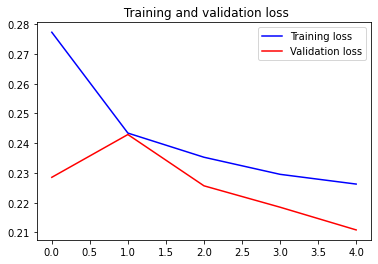

In [101]:
plot_train_history(single_step_history,
                   ' Training and validation loss')

In [58]:
def create_time_steps(length):
  return list(range(-length, 0))

In [59]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

(128, 120, 4)
(128,)


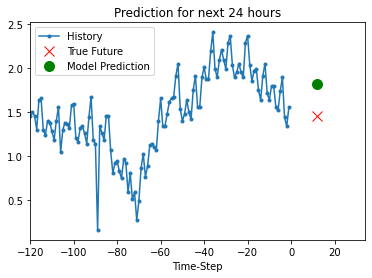

(128, 120, 4)
(128,)


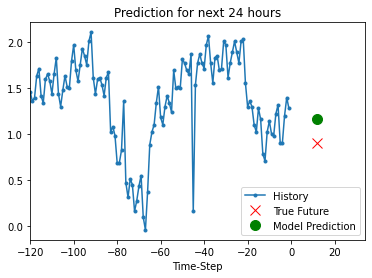

(128, 120, 4)
(128,)


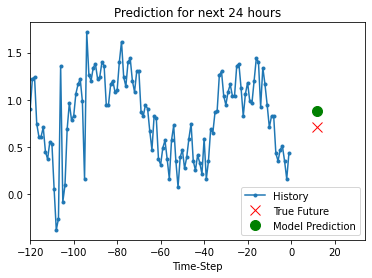

In [60]:
for x, y in test_data_single.take(3):
  print(x.shape)
  print(y.shape)
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Prediction for next 24 hours')
  plot.show()

In [ ]:
a=single_step_model.predict(x_test_single)

In [ ]:
a.shape

In [ ]:
a[:,]